In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sgn





Make two equal noise signals with tau = 10 samples apart

In [59]:


N = 1000
x =  0.5 - np.random.rand(N)


tau = 10

y = np.roll(x, -tau)



Correlate and plot the correlation:

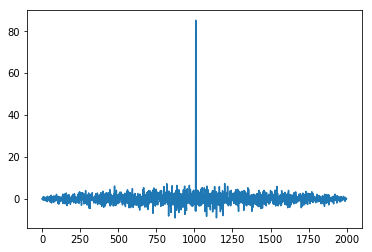

In [3]:

corr = sgn.correlate(x,y)

plt.plot(corr)
plt.show()

Lets zoom in on the first 20 samples

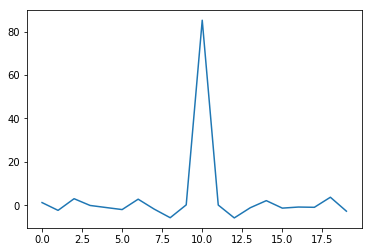

In [4]:
zoom = corr[len(corr)//2:len(corr)//2 + 20]

plt.plot(zoom)
plt.show()

Lets find the maximum of the absolute value of the correlation

In [5]:
def findDelay(corr):
    
    abs_corr = np.abs(corr)

    max_value = np.amax(abs_corr)

    index = np.where(corr == max_value)

    delay = (index[0] - len(corr)//2)[0]
    
    return delay


print("The delay is, in samples: ", findDelay(corr))

The delay is, in samples:  10


To get effective delay in seconds, we have nT = t, and T = 1/Fs. If we for example 44800Hz sampling frequency we get

In [6]:
T = 1 / 44800
n = findDelay(corr)
t = n*T
print("Delay in seconds", t)

Delay in seconds 0.000223214285714


In [231]:

def t (n21,n31,n32):
    y = sqrt3*(n21 + n31)
    x = (n21 - n31 - 2*n32)
    return atan2(y,x)


nmax = 2
def findmaxangles(nmax):
    nplt = np.zeros(10000)
    i = 0
    for n1 in range(-nmax,nmax + 1):
        for n2 in range(-nmax,nmax + 1):
            for n3 in range(-nmax,nmax + 1):

                nplt[i] = t(n1,n2,n3)
                i = i+ 1
    nplt = np.unique(nplt)
    print(len(nplt)," different angles with ", nmax, " maximum delay")
    print("Which gives ", 360/len(nplt), " degree angular resolution")
findmaxangles(2)
findmaxangles(4)
findmaxangles(6)

36  different angles with  2  maximum delay
Which gives  10.0  degree angular resolution
136  different angles with  4  maximum delay
Which gives  2.6470588235294117  degree angular resolution
284  different angles with  6  maximum delay
Which gives  1.267605633802817  degree angular resolution


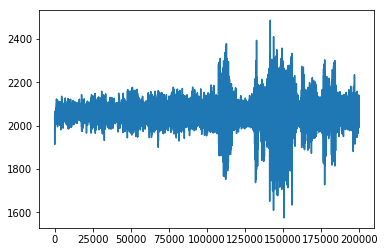

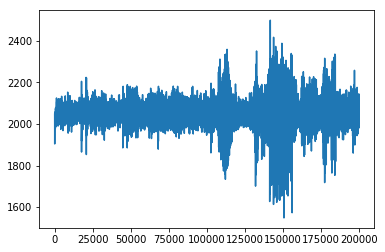

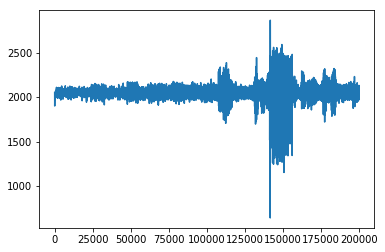

In [7]:


from raspi_import import raspi_import


sample_period, data4 = raspi_import("./out/adcData_mic1.bin")

plt.plot(data4[1:,0])
plt.show()
plt.plot(data4[1:,1])
plt.show()
plt.plot(data4[1:,2])
plt.show()

Fjerne DC-komponent: Normaliserer signalet og fjerner DC-komponent

In [8]:
def prepros (data, maximum = 4096):
    d = data / maximum
    d - 0.5
    return d

res = 4096



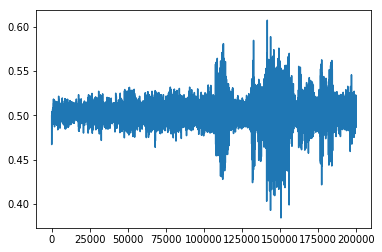

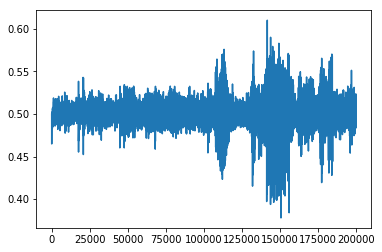

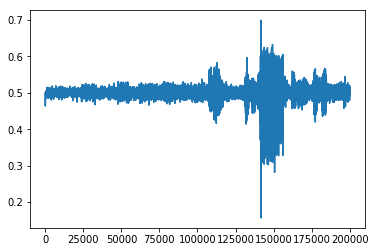

In [9]:
x1 = prepros(data4[1:,0], res)
x2 = prepros(data4[1:,1], res)
x3 = prepros(data4[1:,2], res)

plt.plot(x1)
plt.show()
plt.plot(x2)
plt.show()
plt.plot(x3)
plt.show()


def resample(data, factor):
    return sgn.resample(data, len(data)*factor)

factor = 2

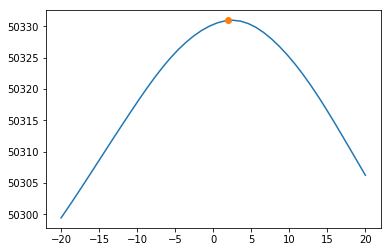

2


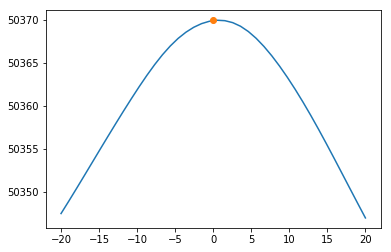

0


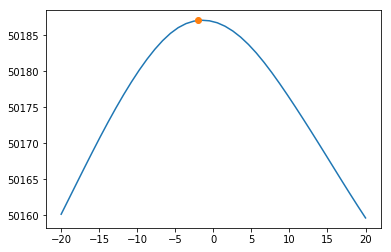

-2


In [208]:


def windowedcorr(x,y, maxlag):
    rxy = np.zeros(2*maxlag)
    for l in range(0, 2*maxlag):
        rxy[l] = np.sum(np.roll(x, maxlag - l)*y) 
    
    return rxy
lag = 20
wcorr= windowedcorr(x1,x3, lag)
#plt.plot(np.linspace(-l, l, lag*2), wcorr)
plt.plot(np.linspace(-lag,lag,lag*2) ,wcorr)
plt.plot(findDelay(wcorr),wcorr[lag + findDelay(wcorr)], marker="o")
plt.show()

print(findDelay(wcorr))
wcorr= windowedcorr(x2,x1, lag)
#plt.plot(np.linspace(-l, l, lag*2), wcorr)
plt.plot(np.linspace(-lag,lag,lag*2) ,wcorr)
plt.plot(findDelay(wcorr),wcorr[lag + findDelay(wcorr)], marker="o")
plt.show()

print(findDelay(wcorr))
wcorr= windowedcorr(x3,x2, lag)
#plt.plot(np.linspace(-l, l, lag*2), wcorr)
plt.plot(np.linspace(-lag,lag,lag*2) ,wcorr)
plt.plot(findDelay(wcorr),wcorr[lag + findDelay(wcorr)], marker="o")
plt.show()

print(findDelay(wcorr))



In [194]:

maxlag = 10
n21 = findDelay(windowedcorr(x2,x1, maxlag))
n31 = findDelay(windowedcorr(x3,x1, maxlag))
n32 = findDelay(windowedcorr(x3,x2, maxlag))

print("Delays in samples: n21: ",n21," n31: ", n31, " n32: ", n32 )

Delays in samples: n21:  0  n31:  -2  n32:  -2


In [152]:

from math import atan2

sqrt3 = 1.73205081

def est_theta (n21,n31,n32):
    p = 0
    y = sqrt3*(n21 + n31)
    x = (n21 - n31 - 2*n32)
    
    return atan2(y,x)

theta = est_theta(n21,n31,n32)

print(theta)

print((theta*180) / (np.pi))


-0.5235987762060795
-30.00000003482327


In [188]:

def estimate_angle (data, res=4096):
    
    x1 = prepros(data[1:,0], res)
    x2 = prepros(data[1:,2], res)
    x3 = prepros(data[1:,1], res)
    
    c21 = windowedcorr(x2,x1, maxlag)
    c31 = windowedcorr(x3,x1, maxlag)
    c32 = windowedcorr(x3,x2, maxlag)
    #plt.plot(c21)
    #plt.plot(c31)
    #plt.plot(c32)
    #plt.show()
    n21 = findDelay(c21)
    #print(n21)
    n31 = findDelay(c31)
    #print(n31)
    n32 = findDelay(c32)
    #print(n32)
    
    theta = est_theta(n21,n31,n32)
    #print(theta)

    #print((theta*180) / (np.pi))
    if(theta < 0):
        theta = theta + 2*np.pi
    return theta

sample_period, data = raspi_import("./out/adcData_mic_180.bin")
theta = estimate_angle(data)


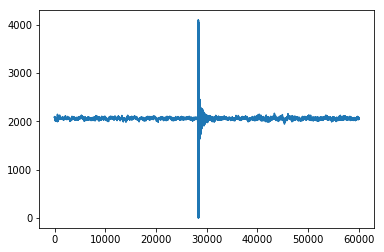

In [163]:
sample_period, temp_data = raspi_import("./out/adcData_mic_315.bin")
plt.plot(temp_data[1:,0])
plt.show()
plt.show()

In [154]:
estimate_angle(temp_data)

-3
-6
-3
-1.0471975518043783
-60.000000034823266


-1.0471975518043783

In [279]:


sample_period, d0 = raspi_import("./out/adcData_mic_0.bin")
sample_period, d45 = raspi_import("./out/adcData_mic_45.bin")
sample_period, d90 = raspi_import("./out/adcData_mic_90.bin")
sample_period, d120 = raspi_import("./out/adcData_mic_120.bin")
sample_period, d145 = raspi_import("./out/adcData_mic_145.bin")
sample_period, d180 = raspi_import("./out/adcData_mic_180.bin")
sample_period, d235 = raspi_import("./out/adcData_mic_235.bin")
sample_period, d245 = raspi_import("./out/adcData_mic_245.bin")
sample_period, d270 = raspi_import("./out/adcData_mic_270.bin")
sample_period, d315 = raspi_import("./out/adcData_mic_315.bin")

arr = np.array([(d0,0,),(d45,45,),(d90,90,),(d120,120,),(d145,145,),(d180,180,),(d235,235,),(d245,245,),(d270,270,),(d315,315,)])
result = np.array([np.zeros((len(arr) )),np.zeros((len(arr))),np.zeros((len(arr)))]).transpose()
text = ("Estimated angle", "Actual angle", "Deviation")
for i in range(len(arr)):
    est = round((estimate_angle(arr[i][0])*180) / (np.pi),2)
    actual = arr[i][1]
    result[i] = [est,actual,round(actual - est,2)]
    
    
from IPython.display import HTML, display

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
        
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in result)
       )
))


print(result[1:,2])

6.59,0.0,-6.59
40.89,45.0,4.11
90.0,90.0,0.0
120.0,120.0,0.0
150.0,145.0,-5.0
186.59,180.0,-6.59
229.11,235.0,5.89
240.0,245.0,5.0
273.67,270.0,-3.67
300.0,315.0,15.0


[  4.11   0.     0.    -5.    -6.59   5.89   5.    -3.67  15.  ]
